In [1]:
import torch
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F
from utils.dataset import CocoDataset
from utils.plots import plot_rgb, reconstruct_lab, plot_losses, plot_model_pred
from utils.models import save_model, load_model
from utils.training import train_gan, load_losses
from utils.metrics import evaluate_model

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

TO DO:
- add unet generator
- put class in utils
- method of improvement: use other losses other than the gan one (wgan, regularized like in paper)

## Data Import

In [3]:
height, width = 256, 256

transform = transforms.Compose([
    transforms.Resize((height, width)),
    transforms.ToTensor(),
])

In [4]:
dataset = CocoDataset(root="coco/images/train2014", transform=transform)

Found 82783 images.


## Data Prep
Consider for now only a small subset of the data (ho copiato baseline.ipynb)

In [5]:
torch.manual_seed(42)
test_size = int(0.2 * len(dataset))
train_size = len(dataset) - test_size
train, test = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train, batch_size=64, shuffle=True)
test_loader = DataLoader(test, batch_size=64, shuffle=False)
train_size = 5000
small_train, _ = random_split(train, [train_size, len(train) - train_size])
small_train_loader = DataLoader(small_train, batch_size=64, shuffle=True)
test_size = 1000
small_test, _ = random_split(test, [test_size, len(test) - test_size])
small_test_loader = DataLoader(small_test, batch_size=64, shuffle=False)

## GAN


In [6]:
# to improve on the results of the cnn we try to use a fully convolutional network
# first we do encoder decoder only and then unet (same as before)
# idea similar to paper Image-to-Image Translation with Conditional Adversarial Networks

class EncoderDecoderGenerator(nn.Module):
    """
    Encoder-decoder generator for image colorization.

    This generator takes a grayscale image as input and outputs the colorized version.

    Attributes:
        encoder (nn.Sequential): Sequential container of encoder convolutional layers, batch normalization, dropout, and leaky ReLU activations.
        decoder (nn.Sequential): Sequential container of decoder convolutional layers, upsampling, batch normalization, and leaky ReLU activations.
        sigmoid (nn.Sigmoid): Sigmoid activation function for the output layer.

    Methods:
        forward(x: torch.Tensor) -> torch.Tensor:
            Defines the forward pass of the generator.
    """

    def __init__(self):
        """
        Initializes the EncoderDecoderGenerator.
        """
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),  # image size: 128x128
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 64x64
            nn.BatchNorm2d(128),
            nn.Dropout2d(0.5),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 32x32
            nn.BatchNorm2d(256),
            nn.Dropout2d(0.5),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 16x16
            nn.BatchNorm2d(512),
            nn.Dropout2d(0.5),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),  # 8x8
            nn.BatchNorm2d(512),
            nn.Dropout2d(0.5),
            nn.LeakyReLU(0.2, inplace=True),
        ) 

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1),  # 16x16
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 32x32
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 64x64
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 128x128
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(64, 2, kernel_size=4, stride=2, padding=1),  # 256x256
        )

        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor):
        """
        Defines the forward pass of the generator.

        Args:
            x (torch.Tensor): Input grayscale image tensor of shape (batch_size, 1, height, width).

        Returns:
            torch.Tensor: Output colorized image tensor of shape (batch_size, 2, height, width).
        """
        x = self.encoder(x)
        x = self.decoder(x)
        return self.sigmoid(x)

# we use a patchgan as a discriminator
# it is just a discriminator that looks at patches, rather than at pixels.
# so instead of outputting a single value, patchgan outptus a map where each
# point refers to probability a patch in the image. 
# this is of course an improvement over pixel wise methods
# we decide to use 70x70 patches.

class PatchGANDiscriminator(nn.Module):
    """
    PatchGAN discriminator for image colorization.

    This discriminator classifies each patch of the input image as real or fake.

    Attributes:
        conv (nn.Sequential): Sequential container of convolutional layers, batch normalization, and leaky ReLU activations.

    Methods:
        forward(x: torch.Tensor) -> torch.Tensor:
            Defines the forward pass of the discriminator.
    """

    def __init__(self):
        """
        Initializes the PatchGANDiscriminator.
        """
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # image size: 128x128
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # 64x64
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), # 32x32
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=3, stride=1, padding="same") # 32x32
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor):
        """
        Defines the forward pass of the discriminator.

        Args:
            x (torch.Tensor): Input image tensor of shape (batch_size, 3, height, width).

        Returns:
            torch.Tensor: Output tensor representing the probability of the input being real. Shape: (batch_size, 1, height, width).
        """
        x = self.conv(x)
        return self.sigmoid(x)

In [7]:
torch.manual_seed(42)

generator_encdec = EncoderDecoderGenerator().to(device)
gen_encdec_opt = optim.Adam(generator_encdec.parameters(), lr=0.0002, betas=(0.5, 0.999))

discriminator_patch = PatchGANDiscriminator().to(device)
discriminator_patch_opt = optim.Adam(discriminator_patch.parameters(), lr=0.0002, betas=(0.5, 0.999))

criterion = nn.BCELoss()

In [8]:
torch.manual_seed(42)
d_losses, g_losses = train_gan(100, discriminator_patch, generator_encdec, discriminator_patch_opt, gen_encdec_opt,
                               criterion, small_train_loader, device, save_losses=True, save_checkpoints=True, file_name="gan_encdec")

Epoch 33/100:   1%|▏         | 1/79 [00:01<02:32,  1.95s/it, d_loss=0.000117, g_loss=9.34]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:   3%|▎         | 2/79 [00:03<02:30,  1.95s/it, d_loss=0.000116, g_loss=9.33]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:   4%|▍         | 3/79 [00:05<02:26,  1.93s/it, d_loss=0.000117, g_loss=9.33]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:   5%|▌         | 4/79 [00:07<02:22,  1.90s/it, d_loss=0.000116, g_loss=9.33]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:   6%|▋         | 5/79 [00:09<02:21,  1.91s/it, d_loss=0.000116, g_loss=9.33]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:   8%|▊         | 6/79 [00:11<02:19,  1.91s/it, d_loss=0.000116, g_loss=9.33]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:   9%|▉         | 7/79 [00:13<02:16,  1.90s/it, d_loss=0.000116, g_loss=9.33]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  10%|█         | 8/79 [00:15<02:14,  1.89s/it, d_loss=0.000115, g_loss=9.33]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  11%|█▏        | 9/79 [00:17<02:12,  1.89s/it, d_loss=0.000115, g_loss=9.33]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  13%|█▎        | 10/79 [00:19<02:10,  1.89s/it, d_loss=0.000114, g_loss=9.33]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  14%|█▍        | 11/79 [00:20<02:07,  1.88s/it, d_loss=0.000114, g_loss=9.33]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  15%|█▌        | 12/79 [00:22<02:06,  1.88s/it, d_loss=0.000114, g_loss=9.33]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  16%|█▋        | 13/79 [00:24<02:03,  1.88s/it, d_loss=0.000113, g_loss=9.33]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  18%|█▊        | 14/79 [00:26<02:02,  1.88s/it, d_loss=0.000113, g_loss=9.34]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  19%|█▉        | 15/79 [00:28<02:00,  1.88s/it, d_loss=0.000113, g_loss=9.34]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  20%|██        | 16/79 [00:30<01:59,  1.90s/it, d_loss=0.000114, g_loss=9.34]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  22%|██▏       | 17/79 [00:32<01:57,  1.90s/it, d_loss=0.000113, g_loss=9.34]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  23%|██▎       | 18/79 [00:34<01:56,  1.90s/it, d_loss=0.000113, g_loss=9.34]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  24%|██▍       | 19/79 [00:36<01:54,  1.91s/it, d_loss=0.000113, g_loss=9.34]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  25%|██▌       | 20/79 [00:37<01:51,  1.90s/it, d_loss=0.000113, g_loss=9.34]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  27%|██▋       | 21/79 [00:39<01:50,  1.90s/it, d_loss=0.000113, g_loss=9.34]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  28%|██▊       | 22/79 [00:41<01:48,  1.90s/it, d_loss=0.000113, g_loss=9.34]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  29%|██▉       | 23/79 [00:43<01:46,  1.90s/it, d_loss=0.000113, g_loss=9.34]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  30%|███       | 24/79 [00:45<01:45,  1.91s/it, d_loss=0.000113, g_loss=9.34]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  32%|███▏      | 25/79 [00:47<01:43,  1.92s/it, d_loss=0.000113, g_loss=9.34]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  33%|███▎      | 26/79 [00:49<01:42,  1.93s/it, d_loss=0.000113, g_loss=9.34]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  34%|███▍      | 27/79 [00:51<01:40,  1.93s/it, d_loss=0.000113, g_loss=9.34]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  35%|███▌      | 28/79 [00:53<01:37,  1.92s/it, d_loss=0.000113, g_loss=9.34]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  37%|███▋      | 29/79 [00:55<01:35,  1.92s/it, d_loss=0.000113, g_loss=9.34]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  38%|███▊      | 30/79 [00:57<01:33,  1.91s/it, d_loss=0.000113, g_loss=9.34]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  39%|███▉      | 31/79 [00:59<01:31,  1.91s/it, d_loss=0.000112, g_loss=9.34]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  41%|████      | 32/79 [01:00<01:29,  1.90s/it, d_loss=0.000112, g_loss=9.34]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  42%|████▏     | 33/79 [01:02<01:27,  1.89s/it, d_loss=0.000112, g_loss=9.34]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  43%|████▎     | 34/79 [01:04<01:24,  1.89s/it, d_loss=0.000112, g_loss=9.34]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  44%|████▍     | 35/79 [01:06<01:23,  1.90s/it, d_loss=0.000112, g_loss=9.34]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  46%|████▌     | 36/79 [01:08<01:21,  1.90s/it, d_loss=0.000112, g_loss=9.34]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  47%|████▋     | 37/79 [01:10<01:19,  1.89s/it, d_loss=0.000112, g_loss=9.34]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  48%|████▊     | 38/79 [01:12<01:17,  1.90s/it, d_loss=0.000112, g_loss=9.34]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  49%|████▉     | 39/79 [01:14<01:16,  1.90s/it, d_loss=0.000112, g_loss=9.35]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  51%|█████     | 40/79 [01:16<01:14,  1.91s/it, d_loss=0.000112, g_loss=9.35]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  52%|█████▏    | 41/79 [01:17<01:12,  1.90s/it, d_loss=0.000112, g_loss=9.35]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  53%|█████▎    | 42/79 [01:19<01:10,  1.91s/it, d_loss=0.000112, g_loss=9.35]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  54%|█████▍    | 43/79 [01:21<01:08,  1.90s/it, d_loss=0.000112, g_loss=9.35]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  56%|█████▌    | 44/79 [01:23<01:06,  1.90s/it, d_loss=0.000112, g_loss=9.35]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  57%|█████▋    | 45/79 [01:25<01:04,  1.90s/it, d_loss=0.000112, g_loss=9.35]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  58%|█████▊    | 46/79 [01:27<01:02,  1.90s/it, d_loss=0.000112, g_loss=9.35]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  59%|█████▉    | 47/79 [01:29<01:00,  1.89s/it, d_loss=0.000112, g_loss=9.35]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  61%|██████    | 48/79 [01:31<00:58,  1.90s/it, d_loss=0.000112, g_loss=9.35]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  62%|██████▏   | 49/79 [01:33<00:56,  1.89s/it, d_loss=0.000112, g_loss=9.35]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  63%|██████▎   | 50/79 [01:35<00:54,  1.90s/it, d_loss=0.000112, g_loss=9.35]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  65%|██████▍   | 51/79 [01:36<00:53,  1.90s/it, d_loss=0.000112, g_loss=9.35]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  66%|██████▌   | 52/79 [01:38<00:51,  1.90s/it, d_loss=0.000112, g_loss=9.35]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  67%|██████▋   | 53/79 [01:40<00:49,  1.89s/it, d_loss=0.000111, g_loss=9.35]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  68%|██████▊   | 54/79 [01:42<00:47,  1.90s/it, d_loss=0.000111, g_loss=9.35]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  70%|██████▉   | 55/79 [01:44<00:45,  1.91s/it, d_loss=0.000111, g_loss=9.35]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  71%|███████   | 56/79 [01:46<00:43,  1.90s/it, d_loss=0.000111, g_loss=9.35]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  72%|███████▏  | 57/79 [01:48<00:41,  1.90s/it, d_loss=0.000111, g_loss=9.35]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  73%|███████▎  | 58/79 [01:50<00:39,  1.90s/it, d_loss=0.000111, g_loss=9.35]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  75%|███████▍  | 59/79 [01:52<00:38,  1.90s/it, d_loss=0.000111, g_loss=9.36]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  76%|███████▌  | 60/79 [01:54<00:36,  1.91s/it, d_loss=0.000111, g_loss=9.36]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  77%|███████▋  | 61/79 [01:56<00:34,  1.91s/it, d_loss=0.000111, g_loss=9.36]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  78%|███████▊  | 62/79 [01:57<00:32,  1.91s/it, d_loss=0.000111, g_loss=9.36]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  80%|███████▉  | 63/79 [01:59<00:30,  1.91s/it, d_loss=0.000111, g_loss=9.36]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  81%|████████  | 64/79 [02:01<00:28,  1.91s/it, d_loss=0.000111, g_loss=9.36]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  82%|████████▏ | 65/79 [02:03<00:26,  1.92s/it, d_loss=0.000111, g_loss=9.36]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  84%|████████▎ | 66/79 [02:05<00:24,  1.92s/it, d_loss=0.000111, g_loss=9.36]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  85%|████████▍ | 67/79 [02:07<00:22,  1.90s/it, d_loss=0.000111, g_loss=9.36]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  86%|████████▌ | 68/79 [02:09<00:20,  1.91s/it, d_loss=0.000111, g_loss=9.36]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  87%|████████▋ | 69/79 [02:11<00:18,  1.90s/it, d_loss=0.000111, g_loss=9.36]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  89%|████████▊ | 70/79 [02:13<00:17,  1.89s/it, d_loss=0.00011, g_loss=9.36] 

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  90%|████████▉ | 71/79 [02:15<00:15,  1.90s/it, d_loss=0.00011, g_loss=9.36]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  91%|█████████ | 72/79 [02:16<00:13,  1.90s/it, d_loss=0.00011, g_loss=9.36]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  92%|█████████▏| 73/79 [02:18<00:11,  1.91s/it, d_loss=0.00011, g_loss=9.36]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  94%|█████████▎| 74/79 [02:20<00:09,  1.90s/it, d_loss=0.00011, g_loss=9.36]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  95%|█████████▍| 75/79 [02:22<00:07,  1.90s/it, d_loss=0.00011, g_loss=9.36]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  96%|█████████▌| 76/79 [02:24<00:05,  1.90s/it, d_loss=0.00011, g_loss=9.36]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  97%|█████████▋| 77/79 [02:26<00:03,  1.90s/it, d_loss=0.00011, g_loss=9.36]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100:  99%|█████████▊| 78/79 [02:28<00:01,  1.91s/it, d_loss=0.00011, g_loss=9.36]

Model saved to models\gan_encdec_33.pth successfully!


Epoch 33/100: 100%|██████████| 79/79 [02:28<00:00,  1.88s/it, d_loss=0.00011, g_loss=9.36]


Model saved to models\gan_encdec_33.pth successfully!


Epoch 66/100:   1%|▏         | 1/79 [00:01<02:29,  1.92s/it, d_loss=1.76e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:   3%|▎         | 2/79 [00:03<02:25,  1.89s/it, d_loss=1.8e-5, g_loss=11.2] 

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:   4%|▍         | 3/79 [00:05<02:23,  1.89s/it, d_loss=1.79e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:   5%|▌         | 4/79 [00:07<02:21,  1.89s/it, d_loss=1.79e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:   6%|▋         | 5/79 [00:09<02:21,  1.91s/it, d_loss=1.83e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:   8%|▊         | 6/79 [00:11<02:18,  1.90s/it, d_loss=1.8e-5, g_loss=11.2] 

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:   9%|▉         | 7/79 [00:13<02:16,  1.89s/it, d_loss=1.81e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  10%|█         | 8/79 [00:15<02:14,  1.90s/it, d_loss=1.84e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  11%|█▏        | 9/79 [00:17<02:13,  1.90s/it, d_loss=1.82e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  13%|█▎        | 10/79 [00:18<02:11,  1.90s/it, d_loss=1.81e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  14%|█▍        | 11/79 [00:20<02:08,  1.89s/it, d_loss=1.81e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  15%|█▌        | 12/79 [00:22<02:06,  1.89s/it, d_loss=1.81e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  16%|█▋        | 13/79 [00:24<02:05,  1.90s/it, d_loss=1.81e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  18%|█▊        | 14/79 [00:26<02:04,  1.91s/it, d_loss=1.81e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  19%|█▉        | 15/79 [00:28<02:02,  1.91s/it, d_loss=1.81e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  20%|██        | 16/79 [00:30<02:01,  1.93s/it, d_loss=1.8e-5, g_loss=11.2] 

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  22%|██▏       | 17/79 [00:32<01:58,  1.91s/it, d_loss=1.81e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  23%|██▎       | 18/79 [00:34<01:57,  1.93s/it, d_loss=1.81e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  24%|██▍       | 19/79 [00:36<01:54,  1.92s/it, d_loss=1.81e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  25%|██▌       | 20/79 [00:38<01:52,  1.91s/it, d_loss=1.81e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  27%|██▋       | 21/79 [00:40<01:52,  1.93s/it, d_loss=1.81e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  28%|██▊       | 22/79 [00:42<01:49,  1.93s/it, d_loss=1.81e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  29%|██▉       | 23/79 [00:43<01:47,  1.91s/it, d_loss=1.81e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  30%|███       | 24/79 [00:45<01:45,  1.91s/it, d_loss=1.81e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  32%|███▏      | 25/79 [00:47<01:42,  1.90s/it, d_loss=1.82e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  33%|███▎      | 26/79 [00:49<01:40,  1.90s/it, d_loss=1.81e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  34%|███▍      | 27/79 [00:51<01:39,  1.91s/it, d_loss=1.81e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  35%|███▌      | 28/79 [00:53<01:37,  1.91s/it, d_loss=1.81e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  37%|███▋      | 29/79 [00:55<01:35,  1.91s/it, d_loss=1.81e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  38%|███▊      | 30/79 [00:57<01:33,  1.92s/it, d_loss=1.81e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  39%|███▉      | 31/79 [00:59<01:32,  1.92s/it, d_loss=1.81e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  41%|████      | 32/79 [01:01<01:30,  1.92s/it, d_loss=1.81e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  42%|████▏     | 33/79 [01:03<01:29,  1.94s/it, d_loss=1.81e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  43%|████▎     | 34/79 [01:05<01:26,  1.93s/it, d_loss=1.81e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  44%|████▍     | 35/79 [01:06<01:24,  1.92s/it, d_loss=1.81e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  46%|████▌     | 36/79 [01:08<01:22,  1.93s/it, d_loss=1.81e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  47%|████▋     | 37/79 [01:10<01:20,  1.91s/it, d_loss=1.8e-5, g_loss=11.2] 

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  48%|████▊     | 38/79 [01:12<01:19,  1.93s/it, d_loss=1.8e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  49%|████▉     | 39/79 [01:14<01:17,  1.94s/it, d_loss=1.8e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  51%|█████     | 40/79 [01:16<01:15,  1.94s/it, d_loss=1.8e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  52%|█████▏    | 41/79 [01:18<01:13,  1.94s/it, d_loss=1.8e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  53%|█████▎    | 42/79 [01:20<01:11,  1.93s/it, d_loss=1.8e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  54%|█████▍    | 43/79 [01:22<01:09,  1.93s/it, d_loss=1.8e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  56%|█████▌    | 44/79 [01:24<01:06,  1.91s/it, d_loss=1.8e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  57%|█████▋    | 45/79 [01:26<01:04,  1.91s/it, d_loss=1.8e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  58%|█████▊    | 46/79 [01:28<01:02,  1.90s/it, d_loss=1.8e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  59%|█████▉    | 47/79 [01:29<01:01,  1.91s/it, d_loss=1.81e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  61%|██████    | 48/79 [01:31<00:59,  1.91s/it, d_loss=1.81e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  62%|██████▏   | 49/79 [01:33<00:57,  1.92s/it, d_loss=1.81e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  63%|██████▎   | 50/79 [01:35<00:55,  1.92s/it, d_loss=1.81e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  65%|██████▍   | 51/79 [01:37<00:53,  1.92s/it, d_loss=1.8e-5, g_loss=11.2] 

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  66%|██████▌   | 52/79 [01:39<00:51,  1.91s/it, d_loss=1.8e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  67%|██████▋   | 53/79 [01:41<00:49,  1.92s/it, d_loss=1.8e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  68%|██████▊   | 54/79 [01:43<00:47,  1.92s/it, d_loss=1.8e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  70%|██████▉   | 55/79 [01:45<00:46,  1.92s/it, d_loss=1.8e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  71%|███████   | 56/79 [01:47<00:44,  1.92s/it, d_loss=1.8e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  72%|███████▏  | 57/79 [01:49<00:41,  1.91s/it, d_loss=1.8e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  73%|███████▎  | 58/79 [01:51<00:40,  1.92s/it, d_loss=1.8e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  75%|███████▍  | 59/79 [01:53<00:38,  1.93s/it, d_loss=1.8e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  76%|███████▌  | 60/79 [01:54<00:36,  1.92s/it, d_loss=1.8e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  77%|███████▋  | 61/79 [01:56<00:34,  1.91s/it, d_loss=1.8e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  78%|███████▊  | 62/79 [01:58<00:32,  1.90s/it, d_loss=1.79e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  80%|███████▉  | 63/79 [02:00<00:30,  1.91s/it, d_loss=1.79e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  81%|████████  | 64/79 [02:02<00:28,  1.92s/it, d_loss=1.79e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  82%|████████▏ | 65/79 [02:04<00:26,  1.91s/it, d_loss=1.79e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  84%|████████▎ | 66/79 [02:06<00:24,  1.91s/it, d_loss=1.79e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  85%|████████▍ | 67/79 [02:08<00:22,  1.91s/it, d_loss=1.79e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  86%|████████▌ | 68/79 [02:10<00:21,  1.93s/it, d_loss=1.79e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  87%|████████▋ | 69/79 [02:12<00:19,  1.95s/it, d_loss=1.79e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  89%|████████▊ | 70/79 [02:14<00:17,  1.93s/it, d_loss=1.79e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  90%|████████▉ | 71/79 [02:16<00:15,  1.93s/it, d_loss=1.79e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  91%|█████████ | 72/79 [02:17<00:13,  1.93s/it, d_loss=1.79e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  92%|█████████▏| 73/79 [02:19<00:11,  1.92s/it, d_loss=1.79e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  94%|█████████▎| 74/79 [02:21<00:09,  1.93s/it, d_loss=1.79e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  95%|█████████▍| 75/79 [02:23<00:07,  1.92s/it, d_loss=1.79e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  96%|█████████▌| 76/79 [02:25<00:05,  1.93s/it, d_loss=1.79e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  97%|█████████▋| 77/79 [02:27<00:03,  1.92s/it, d_loss=1.79e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100:  99%|█████████▊| 78/79 [02:29<00:01,  1.93s/it, d_loss=1.79e-5, g_loss=11.2]

Model saved to models\gan_encdec_66.pth successfully!


Epoch 66/100: 100%|██████████| 79/79 [02:29<00:00,  1.90s/it, d_loss=1.79e-5, g_loss=11.2]


Model saved to models\gan_encdec_66.pth successfully!


Epoch 100/100:   1%|▏         | 1/79 [00:01<02:26,  1.88s/it, d_loss=3.88e-6, g_loss=12.7]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:   3%|▎         | 2/79 [00:03<02:24,  1.88s/it, d_loss=3.81e-6, g_loss=12.7]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:   4%|▍         | 3/79 [00:05<02:23,  1.89s/it, d_loss=3.83e-6, g_loss=12.7]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:   5%|▌         | 4/79 [00:07<02:23,  1.91s/it, d_loss=3.84e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:   6%|▋         | 5/79 [00:09<02:22,  1.93s/it, d_loss=3.85e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:   8%|▊         | 6/79 [00:11<02:23,  1.97s/it, d_loss=3.84e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:   9%|▉         | 7/79 [00:13<02:19,  1.94s/it, d_loss=3.82e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  10%|█         | 8/79 [00:15<02:17,  1.94s/it, d_loss=3.85e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  11%|█▏        | 9/79 [00:17<02:15,  1.94s/it, d_loss=3.84e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  13%|█▎        | 10/79 [00:19<02:13,  1.93s/it, d_loss=3.85e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  14%|█▍        | 11/79 [00:21<02:11,  1.93s/it, d_loss=3.84e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  15%|█▌        | 12/79 [00:23<02:08,  1.92s/it, d_loss=3.85e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  16%|█▋        | 13/79 [00:25<02:07,  1.93s/it, d_loss=3.85e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  18%|█▊        | 14/79 [00:26<02:05,  1.93s/it, d_loss=3.84e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  19%|█▉        | 15/79 [00:28<02:03,  1.92s/it, d_loss=3.84e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  20%|██        | 16/79 [00:30<02:00,  1.92s/it, d_loss=3.83e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  22%|██▏       | 17/79 [00:32<01:58,  1.91s/it, d_loss=3.82e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  23%|██▎       | 18/79 [00:34<01:56,  1.90s/it, d_loss=3.83e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  24%|██▍       | 19/79 [00:36<01:54,  1.91s/it, d_loss=3.82e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  25%|██▌       | 20/79 [00:38<01:52,  1.90s/it, d_loss=3.83e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  27%|██▋       | 21/79 [00:40<01:50,  1.90s/it, d_loss=3.84e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  28%|██▊       | 22/79 [00:42<01:48,  1.90s/it, d_loss=3.85e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  29%|██▉       | 23/79 [00:44<01:46,  1.91s/it, d_loss=3.85e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  30%|███       | 24/79 [00:46<01:45,  1.92s/it, d_loss=3.85e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  32%|███▏      | 25/79 [00:47<01:43,  1.92s/it, d_loss=3.84e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  33%|███▎      | 26/79 [00:49<01:41,  1.91s/it, d_loss=3.84e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  34%|███▍      | 27/79 [00:51<01:38,  1.90s/it, d_loss=3.84e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  35%|███▌      | 28/79 [00:53<01:37,  1.92s/it, d_loss=3.85e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  37%|███▋      | 29/79 [00:55<01:35,  1.91s/it, d_loss=3.84e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  38%|███▊      | 30/79 [00:57<01:32,  1.90s/it, d_loss=3.84e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  39%|███▉      | 31/79 [00:59<01:32,  1.93s/it, d_loss=3.84e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  41%|████      | 32/79 [01:01<01:30,  1.93s/it, d_loss=3.84e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  42%|████▏     | 33/79 [01:03<01:28,  1.93s/it, d_loss=3.85e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  43%|████▎     | 34/79 [01:05<01:26,  1.92s/it, d_loss=3.84e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  44%|████▍     | 35/79 [01:07<01:24,  1.93s/it, d_loss=3.84e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  46%|████▌     | 36/79 [01:09<01:22,  1.91s/it, d_loss=3.84e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  47%|████▋     | 37/79 [01:10<01:20,  1.91s/it, d_loss=3.84e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  48%|████▊     | 38/79 [01:12<01:18,  1.91s/it, d_loss=3.83e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  49%|████▉     | 39/79 [01:14<01:16,  1.92s/it, d_loss=3.83e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  51%|█████     | 40/79 [01:16<01:14,  1.92s/it, d_loss=3.83e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  52%|█████▏    | 41/79 [01:18<01:13,  1.93s/it, d_loss=3.83e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  53%|█████▎    | 42/79 [01:20<01:11,  1.93s/it, d_loss=3.83e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  54%|█████▍    | 43/79 [01:22<01:09,  1.94s/it, d_loss=3.83e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  56%|█████▌    | 44/79 [01:24<01:07,  1.93s/it, d_loss=3.83e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  57%|█████▋    | 45/79 [01:26<01:05,  1.93s/it, d_loss=3.83e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  58%|█████▊    | 46/79 [01:28<01:03,  1.92s/it, d_loss=3.82e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  59%|█████▉    | 47/79 [01:30<01:01,  1.93s/it, d_loss=3.82e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  61%|██████    | 48/79 [01:32<00:59,  1.93s/it, d_loss=3.82e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  62%|██████▏   | 49/79 [01:34<00:57,  1.93s/it, d_loss=3.82e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  63%|██████▎   | 50/79 [01:35<00:55,  1.92s/it, d_loss=3.82e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  65%|██████▍   | 51/79 [01:37<00:53,  1.92s/it, d_loss=3.82e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  66%|██████▌   | 52/79 [01:39<00:51,  1.91s/it, d_loss=3.82e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  67%|██████▋   | 53/79 [01:41<00:49,  1.91s/it, d_loss=3.82e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  68%|██████▊   | 54/79 [01:43<00:47,  1.91s/it, d_loss=3.81e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  70%|██████▉   | 55/79 [01:45<00:45,  1.91s/it, d_loss=3.81e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  71%|███████   | 56/79 [01:47<00:44,  1.92s/it, d_loss=3.81e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  72%|███████▏  | 57/79 [01:49<00:42,  1.91s/it, d_loss=3.81e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  73%|███████▎  | 58/79 [01:51<00:40,  1.91s/it, d_loss=3.81e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  75%|███████▍  | 59/79 [01:53<00:38,  1.92s/it, d_loss=3.81e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  76%|███████▌  | 60/79 [01:55<00:36,  1.92s/it, d_loss=3.81e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  77%|███████▋  | 61/79 [01:57<00:34,  1.92s/it, d_loss=3.81e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  78%|███████▊  | 62/79 [01:58<00:32,  1.92s/it, d_loss=3.8e-6, g_loss=12.8] 

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  80%|███████▉  | 63/79 [02:00<00:30,  1.92s/it, d_loss=3.8e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  81%|████████  | 64/79 [02:02<00:28,  1.91s/it, d_loss=3.8e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  82%|████████▏ | 65/79 [02:04<00:26,  1.91s/it, d_loss=3.8e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  84%|████████▎ | 66/79 [02:06<00:25,  1.92s/it, d_loss=3.8e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  85%|████████▍ | 67/79 [02:08<00:23,  1.93s/it, d_loss=3.8e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  86%|████████▌ | 68/79 [02:10<00:21,  1.93s/it, d_loss=3.8e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  87%|████████▋ | 69/79 [02:12<00:19,  1.93s/it, d_loss=3.8e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  89%|████████▊ | 70/79 [02:14<00:17,  1.93s/it, d_loss=3.79e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  90%|████████▉ | 71/79 [02:16<00:15,  1.93s/it, d_loss=3.79e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  91%|█████████ | 72/79 [02:18<00:13,  1.93s/it, d_loss=3.79e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  92%|█████████▏| 73/79 [02:20<00:11,  1.93s/it, d_loss=3.79e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  94%|█████████▎| 74/79 [02:22<00:09,  1.94s/it, d_loss=3.79e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  95%|█████████▍| 75/79 [02:24<00:07,  1.94s/it, d_loss=3.78e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  96%|█████████▌| 76/79 [02:25<00:05,  1.94s/it, d_loss=3.78e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  97%|█████████▋| 77/79 [02:27<00:03,  1.93s/it, d_loss=3.78e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100:  99%|█████████▊| 78/79 [02:29<00:01,  1.92s/it, d_loss=3.78e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!


Epoch 100/100: 100%|██████████| 79/79 [02:30<00:00,  1.90s/it, d_loss=3.86e-6, g_loss=12.8]

Model saved to models\gan_encdec_100.pth successfully!
Losses saved to losses\gan_encdec_losses.txt
Finished Training


In [9]:
save_model(generator_encdec, "gan_encdec_generator_final")

Model saved to models\gan_encdec_generator_final.pth successfully!


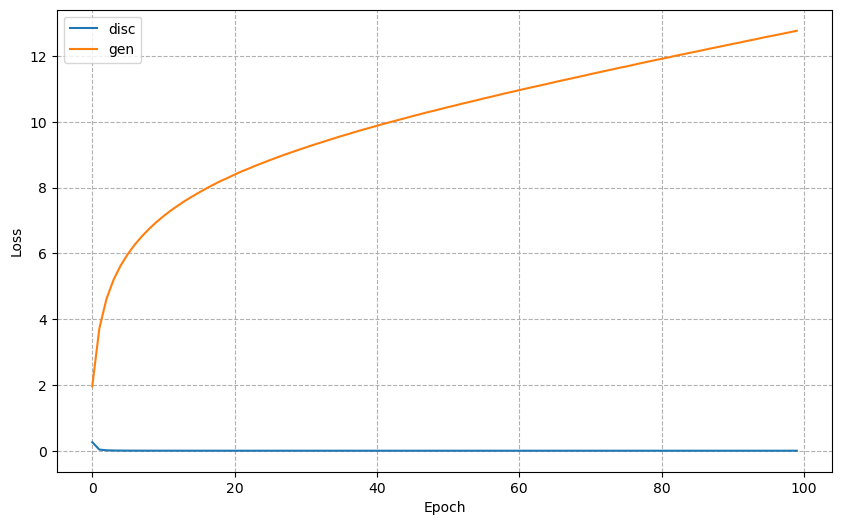

In [10]:
plot_losses(d_losses, g_losses, "disc", "gen")

c:\Users\sandr\Desktop\ML\project\image-colorization\utils\plots.py:129: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 58 negative Z values that have been clipped to zero
  rgb_image = lab2rgb(lab_image_reconstructed)


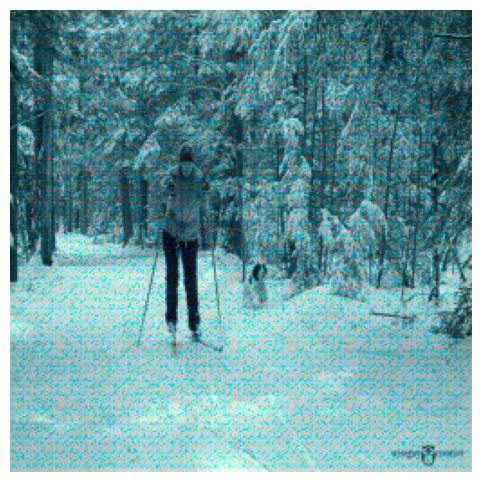

In [21]:
plot_model_pred(dataset[5116][1], generator_encdec)

In [13]:
torch.manual_seed(42)
avg_mse, avg_psnr, avg_ssim, fid = evaluate_model(generator_encdec, small_test_loader, device)
print(f"Average MSE: {avg_mse:.4f}")
print(f"Average PSNR: {avg_psnr:.4f}")
print(f"Average SSIM: {avg_ssim:.4f}")
print(f"FID: {fid:.4f}")

Average MSE: 0.0177
Average PSNR: 35.0578
Average SSIM: 0.0715
FID: 294.7566


EncoderDecoderGenerator model loaded successfully!


c:\Users\sandr\Desktop\ML\project\image-colorization\utils\plots.py:129: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 5029 negative Z values that have been clipped to zero
  rgb_image = lab2rgb(lab_image_reconstructed)


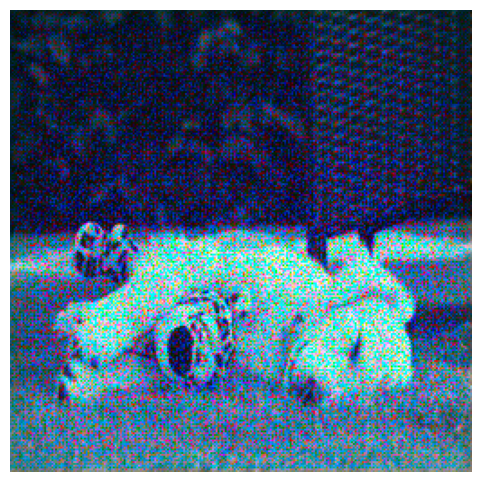

In [17]:
epoch33 = load_model(EncoderDecoderGenerator(), "models/gan_encdec_66.pth").to(device)
plot_model_pred(dataset[5764][1], epoch33)

In [8]:
# def train_discriminator(discriminator, generator, disc_opt, l, ab, criterion, device):
#     disc_opt.zero_grad()

#     real_ab = ab
#     real_output = discriminator(l, real_ab)
#     real_loss = criterion(real_output.reshape(-1), torch.ones_like(real_output, device = device).reshape(-1))
    
#     fake_ab = generator(l)
#     fake_output = discriminator(l, fake_ab.detach())
#     fake_loss = criterion(fake_output.reshape(-1), torch.zeros_like(fake_output, device = device).reshape(-1))
    
#     d_loss = (real_loss + fake_loss) / 2
#     d_loss.backward()
#     disc_opt.step()
    
#     return d_loss

# def train_generator(discriminator, generator, gen_opt, l, criterion, device):
#     gen_opt.zero_grad()
    
#     fake_ab = generator(l)
#     fake_output = discriminator(l, fake_ab)
#     g_loss = criterion(fake_output.reshape(-1), torch.ones_like(fake_output, device = device).reshape(-1))
#     g_loss.backward()
#     gen_opt.step()
#     return g_loss

# # we don't want to train the discriminator more than the the generator,
# # like they do in the original paper. this is because if the discrimintaor
# # gets good at recognizing true/colorized images, it will only do that by measuring the pixels.
# # instead we deem an image to be colorized well even if the color is not the same as the original.
# # for example, if in an image the t-shirt color is blue and the model is able to colorize it properly
# # (i.e. uniformly, shadows, etc.) but in red, we (humans) still consider that
# # colorized image good, but the discriminator does not, so then the generator learns in a bad way.
# # a way to improve this could be having a patch gan discriminator!

# # in general it's important to note that the loss values alone do not provide a complete picture
# # of the generator's performance. It's essential to visually inspect the generated colorized
# # images to assess their quality and realism.

# def train(train_dl, discriminator, generator, disc_opt, gen_opt, criterion, epochs = 15):
    
#     d_losses_train = []
#     g_losses_train = []

#     for epoch in range(epochs):

#         generator.train()
#         discriminator.train()
#         epoch_d_loss_train = 0
#         epoch_g_loss_train = 0
        
#         loop = tqdm(train_dl, leave=True, desc=f"Epoch {epoch+1}/{epochs}")

#         for rgb, l, _, _, ab in loop:
            
#             rgb = rgb.to(device)
#             l = l.to(device)
#             ab = ab.to(device)

#             d_loss_train = train_discriminator(discriminator, generator, disc_opt, l, ab, criterion, device)
#             epoch_d_loss_train += d_loss_train.item()

#             g_loss_train = train_generator(discriminator, generator, gen_opt, l, criterion, device)
#             epoch_g_loss_train += g_loss_train.item()

#             loop.set_postfix(d_loss=epoch_d_loss_train / (loop.n + 1), g_loss=epoch_g_loss_train / (loop.n + 1))

#         d_losses_train.append(epoch_d_loss_train / len(small_train_loader))
#         g_losses_train.append(epoch_g_loss_train / len(small_train_loader))
        
#         if epoch in [int(epochs / 4), 2 * int(epochs / 4),3 * int(epochs / 4), epochs - 1]: # save four checkpoints
#             save_model(generator_cnn, f"generator_cnn_epoch{epoch + 1}")
    
#     print("Training complete!")
#     return d_losses_train, g_losses_train

In [9]:
# it is expected for the discriminator's loss to decrease and the generator's loss
# to increase during the initial stages of training in a GAN setup. This behavior
# is commonly observed and is a part of the adversarial training process.
# In the beginning, both the generator and discriminator are relatively untrained,
# and their outputs are essentially random noise. As a result, their losses are
# typically high but close to each other. However, as training progresses, the
# discriminator starts to learn faster and becomes better at distinguishing real
# samples from the generator's fake samples. At this point, the discriminator's
# loss decreases as it becomes more accurate at identifying real and fake samples.
# Conversely, the generator's loss increases because its samples are now easily
# recognized as fake by the improving discriminator. This creates a gap between
# the generator's and discriminator's losses. The generator then has to adapt and
# learn to generate more realistic samples that can fool the increasingly powerful
# discriminator. This adversarial process continues, with the generator trying to
# catch up to the discriminator by generating better samples, while the discriminator
# keeps improving to distinguish real from fake samples.Eventually, if training
# is successful, the generator's and discriminator's losses should converge to an
# equilibrium, where the generator produces samples that are indistinguishable from
# real samples for the discriminator, and the discriminator cannot reliably distinguish
# real from fake samples.

In [10]:
# torch.manual_seed(42)
# d_losses_cnn, g_losses_cnn = train(small_train_loader, discriminator_cnn, generator_cnn,
#                                    disc_cnn_opt, gen_cnn_opt, criterion_bce, 100)

Epoch 26/100: 100%|██████████| 79/79 [01:17<00:00,  1.02it/s, d_loss=0.0133, g_loss=4.62]


Model saved to models\generator_cnn_epoch26.pth successfully!


Epoch 51/100: 100%|██████████| 79/79 [01:17<00:00,  1.02it/s, d_loss=0.274, g_loss=2.21]


Model saved to models\generator_cnn_epoch51.pth successfully!


Epoch 76/100: 100%|██████████| 79/79 [01:16<00:00,  1.03it/s, d_loss=0.381, g_loss=1.71]


Model saved to models\generator_cnn_epoch76.pth successfully!


Epoch 100/100: 100%|██████████| 79/79 [01:17<00:00,  1.02it/s, d_loss=0.119, g_loss=3.35]


Model saved to models\generator_cnn_epoch100.pth successfully!
Training complete!


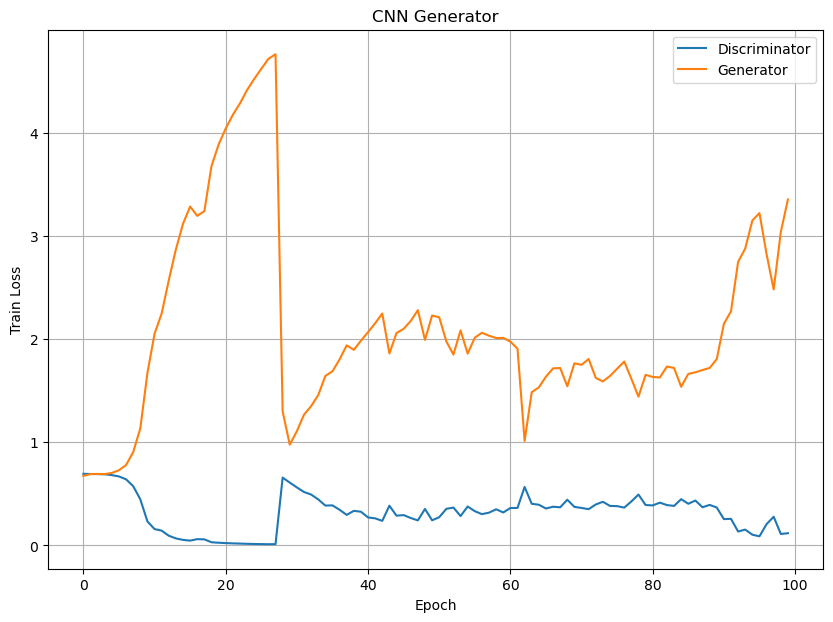

In [11]:
plt.figure(figsize=(10, 7))
plt.plot(d_losses_cnn, label='Discriminator')
plt.plot(g_losses_cnn, label='Generator')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('CNN Generator')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
save_model(generator_cnn, "generator_cnn_trained")

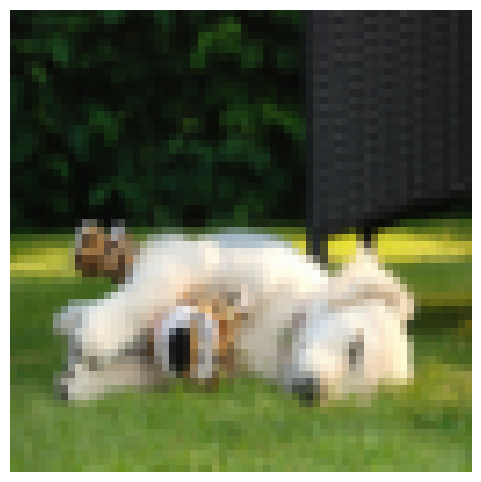

c:\Users\sandr\Desktop\ML\project\image-colorization\utils\plots.py:92: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 12 negative Z values that have been clipped to zero
  rgb_image = lab2rgb(lab_image_reconstructed)


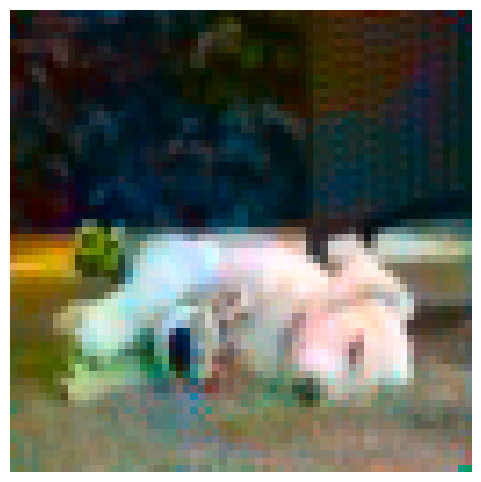

In [46]:
# check for mode collapse:
# so whether we get the same colors to different images
# if so use different loss (wgan)

input = dataset[5764][1].to(device).unsqueeze(0)
ab = generator_cnn(input).squeeze(0)
plot_rgb(dataset[5764][0])
reconstruct_lab(dataset[5764][1].to(device).detach().cpu(), ab.detach().cpu())

GeneratorCNN model loaded successfully!


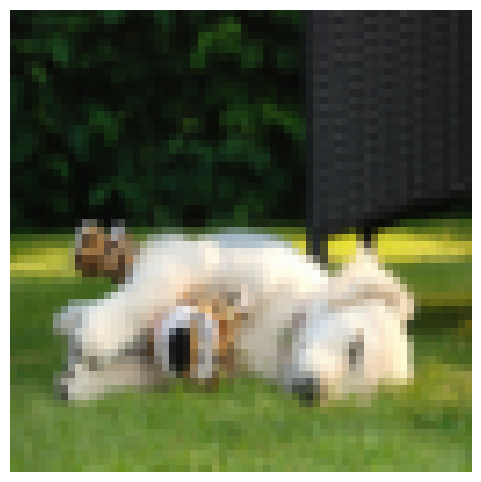

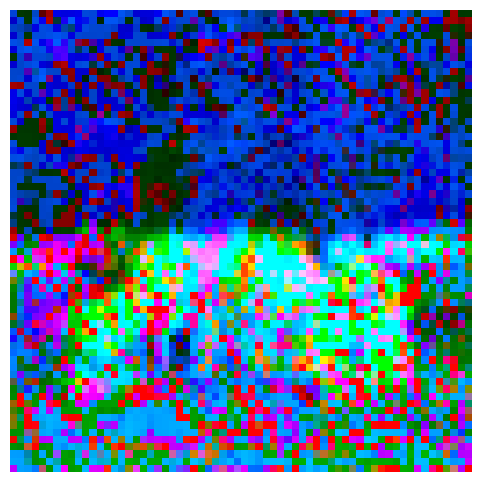

In [48]:
loaded = load_model(GeneratorCNN(), "models/generator_cnn_epoch26.pth")
input = dataset[5764][1].unsqueeze(0)
ab = loaded(input).squeeze(0)
plot_rgb(dataset[5764][0])
reconstruct_lab(dataset[5764][1].to(device).detach().cpu(), ab.detach().cpu())

# Load and Eval

In [50]:
def eval(loaded_model):
    loaded_model.eval()

    total_mse = 0
    total_psnr = 0
    num_samples = 0

    with torch.no_grad():
        for _, l_channels, _, _, ab_channels in small_test_loader:
            l_channels = l_channels.to(device)
            ab_channels = ab_channels.to(device)

            ab_preds = loaded_model(l_channels)

            mse = F.mse_loss(ab_preds, ab_channels)
            total_mse += mse.item() * ab_channels.size(0)

            max_pixel_value = 1  # image values are between 0 and 1
            psnr = 20 * torch.log10(max_pixel_value**2 / mse)
            total_psnr += psnr.item() * ab_channels.size(0)

            num_samples += ab_channels.size(0)

    avg_mse = total_mse / num_samples
    avg_psnr = total_psnr / num_samples

    print(f"Average MSE: {avg_mse:.4f}")
    print(f"Average PSNR: {avg_psnr:.4f}")
    # note: if you run this cell over and over you get slighly different values in the 
    # decimal places for avg psnr possibly because of numerical errors, since when
    # we divide by mse, that value is very small and then we take the log of that,
    # so there can be "errors" of this type to keep in mind.

In [53]:
torch.manual_seed(42)
eval(generator_cnn)

Average MSE: 0.0080
Average PSNR: 41.9989
